# RL
### Index
- [Experiment 1: Slippery vs Non slippery](#experiment-1-slippery-vs-non-slippery)
- [Experiment 2: Q-learning vs Boltzmann](#experiment-2-q-learning-vs-boltzmann)
- [Experiment 3: How Q-values propagate (craving) and show optimal policies with arrows](#experiment-3-how-q-values-propagate-craving-and-show-optimal-policies-with-arrows)
- [Experiment 4: Comparison of different reward_hole values](#experiment-4-comparison-of-different-reward_hole-values)
- [Experiment 5: Experience replay](#experiment-5-experience-replay)
- [Experiment 6: Providing frozen lake layout](#experiment-6--providing-frozen-lake-layout)

# Imports

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
# from tqdm import tqdm
# from collections import deque
import seaborn as sns
# from matplotlib.patches import Arrow
from collections import deque
import random

# Experiment 1: Slippery vs Non slippery

### Enviroment and Config

In [2]:
# Set random seeds for reproducibility
SEEDS = [42, 123, 456]  
np.random.seed(42)

# Configuration - now with both slippery conditions
class Config:
    def __init__(self, slippery=True):
        self.alpha = 0.8
        self.gamma = 0.95
        self.epsilon = 1.0
        self.min_epsilon = 0.05
        self.epsilon_decay = 0.9999
        self.episodes = 30000
        self.eval_episodes = 1000
        self.slippery = slippery  # Now configurable
        self.reward_goal = 20
        self.reward_hole = -1
        self.reward_step = -0.01

### Core Algorithm

In [3]:
def train_q_learning(config, env, seed):
    """Train Q-learning with ε-greedy exploration"""
    np.random.seed(seed)
    env.reset(seed=seed)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []
    
    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            if np.random.random() < config.epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Reward shaping
            if terminated and reward == 0:
                reward = config.reward_hole
            elif reward == 1:
                reward = config.reward_goal
            else:
                reward = config.reward_step
            
            # Q-learning update
            q_table[state, action] += config.alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )
            
            state = next_state
            total_reward += reward
        
        # Decay epsilon
        config.epsilon = max(config.min_epsilon, config.epsilon * config.epsilon_decay)
        episode_rewards.append(total_reward)
    
    return q_table, episode_rewards

def evaluate(q_table, config, seed):
    """Evaluate the learned policy"""
    eval_env = gym.make(
        "FrozenLake-v1",
        desc=["SFFF", "FHFH", "FFFH", "HFFG"],
        is_slippery=config.slippery
    )
    eval_env.reset(seed=seed+1000)
    successes = 0
    
    for _ in range(config.eval_episodes):
        state, _ = eval_env.reset()
        done = False
        
        while not done:
            action = np.argmax(q_table[state])
            state, _, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            if terminated and state == 15:  # Goal state
                successes += 1
    
    return successes / config.eval_episodes

### Experiment Runner

In [4]:
def run_slippery_comparison(seeds=SEEDS):
    """Compare slippery vs non-slippery performance"""
    results = []
    
    # Initialize results storage
    for seed in seeds:
        results.append({
            'seed': seed,
            'slippery': {'rewards': None, 'success_rate': None},
            'non_slippery': {'rewards': None, 'success_rate': None}
        })
    
    # Train and evaluate both conditions
    for condition in [True, False]:
        config = Config(slippery=condition)
        condition_name = 'slippery' if condition else 'non_slippery'
        
        for seed_data in results:
            seed = seed_data['seed']
            env = gym.make(
                "FrozenLake-v1",
                desc=["SFFF",
                      "FHFH", 
                      "FFFH", 
                      "HFFG"],
                is_slippery=condition
            )
            
            q_table, rewards = train_q_learning(config, env, seed)
            success_rate = evaluate(q_table, config, seed)
            
            seed_data[condition_name]['rewards'] = rewards
            seed_data[condition_name]['success_rate'] = success_rate
    
    # Print results grouped by seed
    for seed_data in results:
        print(f"Seed {seed_data['seed']}:")
        print(f"  Slippery: {seed_data['slippery']['success_rate']:.1%}")
        print(f"  Non-slippery: {seed_data['non_slippery']['success_rate']:.1%}")
        print()
    
    return results

def plot_slippery_comparison(results):
    """Plot comparison of slippery vs non-slippery"""
    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting
    for condition in ['slippery', 'non_slippery']:
        # Get all rewards for this condition
        all_rewards = [seed_data[condition]['rewards'] for seed_data in results]
        
        # Compute moving average (window=1000)
        ma_rewards = np.mean([
            np.convolve(r, np.ones(1000)/1000, mode='valid') 
            for r in all_rewards
        ], axis=0)
        
        # Compute average success rate
        avg_success = np.mean([seed_data[condition]['success_rate'] for seed_data in results])
        
        # Plot
        plt.plot(ma_rewards, 
                 label=f"{condition.title()} (Avg SR: {avg_success:.1%})",
                 linewidth=2)
    
    plt.title("Slippery vs Non-slippery Performance (1000-episode MA)", fontsize=14)
    plt.xlabel("Episode", fontsize=12)
    plt.ylabel("Reward", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.xlim(0, 29000)  # Adjust for moving average window
    plt.show()

### Main Execution

Seed 42:
  Slippery: 74.1%
  Non-slippery: 100.0%

Seed 123:
  Slippery: 55.5%
  Non-slippery: 100.0%

Seed 456:
  Slippery: 24.8%
  Non-slippery: 100.0%



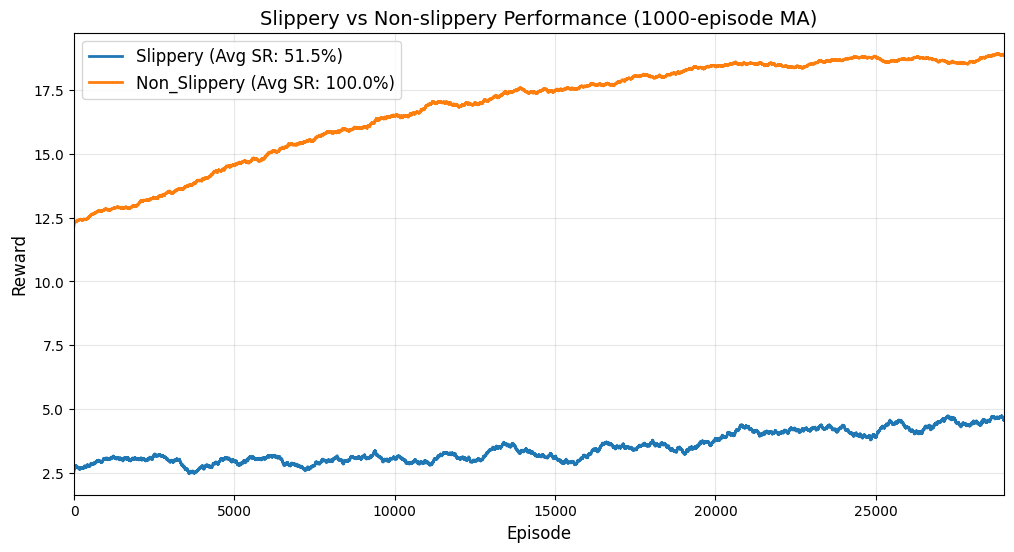


Final Success Rates:
Slippery: μ = 51.5%, σ = 20.3%
Non-slippery: μ = 100.0%, σ = 0.0%


In [5]:
# Run the comparison
results = run_slippery_comparison()

# Generate comparison plot
plot_slippery_comparison(results)

# Print final statistics (updated to match new results structure)
print("\nFinal Success Rates:")
slippery_rates = [seed_data['slippery']['success_rate'] for seed_data in results]
non_slippery_rates = [seed_data['non_slippery']['success_rate'] for seed_data in results]

print(f"Slippery: μ = {np.mean(slippery_rates):.1%}, σ = {np.std(slippery_rates):.1%}")
print(f"Non-slippery: μ = {np.mean(non_slippery_rates):.1%}, σ = {np.std(non_slippery_rates):.1%}")

# Experiment 2: Q-learning vs Boltzmann

### Enviroment and Config

In [27]:
# Set random seeds for reproducibility
SEEDS = [42, 123, 456]  # Reduced to 3 seeds
np.random.seed(42)  # Global seed for additional numpy operations

# Environment setup
def create_env(slippery=True):
    return gym.make(
        "FrozenLake-v1",
        desc=["SFFF", 
              "FHFH", 
              "FFFH", 
              "HFFG"],
        is_slippery=slippery
    )

# Configuration
class Config:
    def __init__(self):
        self.alpha = 0.8       # Learning rate
        self.gamma = 0.95      # Discount factor
        self.epsilon = 1.0     # Initial exploration rate
        self.min_epsilon = 0.05
        self.epsilon_decay = 0.9999
        self.episodes = 30000
        self.eval_episodes = 1000
        self.slippery = True
        self.reward_goal = 20
        self.reward_hole = -1
        self.reward_step = -0.01

### Core Algorithms

In [ ]:
def boltzmann_exploration(q_values, temp=1.0):
    if temp <= 0:
        return np.argmax(q_values)
    
    # Subtract max for numerical stability and apply temperature
    scaled_q = (q_values - np.max(q_values)) / max(temp, 1e-10)  # Avoid division by zero
    exp_q = np.exp(scaled_q)
    probabilities = exp_q / np.sum(exp_q)
    
    # Handle cases where all Q-values are equal
    if np.isnan(probabilities).any():
        probabilities = np.ones_like(q_values) / len(q_values)
    
    return np.random.choice(len(q_values), p=probabilities)

def train_epsilon_greedy(config, env, seed):
    np.random.seed(seed)
    env.reset(seed=seed)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []
    
    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            if np.random.random() < config.epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Reward shaping
            if terminated and reward == 0:
                reward = config.reward_hole
            elif reward == 1:
                reward = config.reward_goal
            else:
                reward = config.reward_step
            
            # Q-learning update
            q_table[state, action] += config.alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )
            
            state = next_state
            total_reward += reward
        
        # Decay epsilon
        config.epsilon = max(config.min_epsilon, config.epsilon * config.epsilon_decay)
        episode_rewards.append(total_reward)
    
    return q_table, episode_rewards

def train_boltzmann(config, env, seed, initial_temp=1.0, temp_decay=0.9995, min_temp=0.1):
    np.random.seed(seed)
    env.reset(seed=seed)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []
    temperature = initial_temp
    
    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            action = boltzmann_exploration(q_table[state], temperature)
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Enhanced reward shaping
            if terminated:
                reward = config.reward_goal if reward == 1 else config.reward_hole
            else:
                # Add distance-based shaping for better guidance
                row, col = divmod(state, 4)
                goal_dist = abs(row-3) + abs(col-3)
                reward = config.reward_step + 0.01 * (6 - goal_dist)  # Max dist=6
            
            # Q-learning update with learning rate decay
            current_alpha = config.alpha * (1 - episode/config.episodes)  # Linear decay
            q_table[state, action] += current_alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )
            
            state = next_state
            total_reward += reward
        
        # Temperature decay
        temperature = max(min_temp, temperature * temp_decay)
        episode_rewards.append(total_reward)
    
    return q_table, episode_rewards

### Evaluation & Heatmap Visualization

In [29]:
def evaluate(q_table, config, seed):
    """Evaluate the learned policy"""
    eval_env = create_env(config.slippery)
    eval_env.reset(seed=seed+1000)  # Different seed for evaluation
    successes = 0
    
    for _ in range(config.eval_episodes):
        state, _ = eval_env.reset()
        done = False
        
        while not done:
            action = np.argmax(q_table[state])
            state, _, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            if terminated and state == 15:  # Goal state
                successes += 1
    
    return successes / config.eval_episodes

def plot_side_by_side(q_epsilon, q_boltzmann, seed, eps_success, boltz_success):
    """Plot both Q-tables side by side"""
    plt.figure(figsize=(16, 6))
    
    # ε-greedy plot
    plt.subplot(1, 2, 1)
    sns.heatmap(q_epsilon, annot=True, fmt=".1f", cmap="viridis", 
                cbar_kws={'label': 'Q-value'}, vmin=-1, vmax=20)
    plt.title(f"ε-greedy (Success: {eps_success:.1%})", pad=20)
    plt.xlabel("Action")
    plt.ylabel("State")
    
    # Boltzmann plot
    plt.subplot(1, 2, 2)
    sns.heatmap(q_boltzmann, annot=True, fmt=".1f", cmap="viridis", 
                cbar_kws={'label': 'Q-value'}, vmin=-1, vmax=20)
    plt.title(f"Boltzmann (Success: {boltz_success:.1%})", pad=20)
    plt.xlabel("Action")
    plt.ylabel("State")
    
    plt.suptitle(f"Seed {seed} Q-table Comparison", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

### Experiment Runner

In [30]:
def run_comparison(config, seeds=SEEDS, temp=1.0):
    """Run and compare both exploration strategies"""
    results = []
    
    for seed in seeds:
        # Train both strategies
        config.epsilon = 1.0  # Reset exploration rate
        env = create_env(config.slippery)
        q_epsilon, _ = train_epsilon_greedy(config, env, seed)
        eps_success = evaluate(q_epsilon, config, seed)
        
        env = create_env(config.slippery)
        q_boltzmann, _ = train_boltzmann(config, env, seed, temp)
        boltz_success = evaluate(q_boltzmann, config, seed)
        
        # Store results
        results.append((seed, eps_success, boltz_success))
        
        # Print and visualize
        print(f"Seed {seed} success rates: ε-greedy: {eps_success:.1%}, Boltzmann: {boltz_success:.1%}")
        plot_side_by_side(q_epsilon, q_boltzmann, seed, eps_success, boltz_success)
    
    return results

### Execution

Seed 42 success rates: ε-greedy: 39.0%, Boltzmann: 59.9%


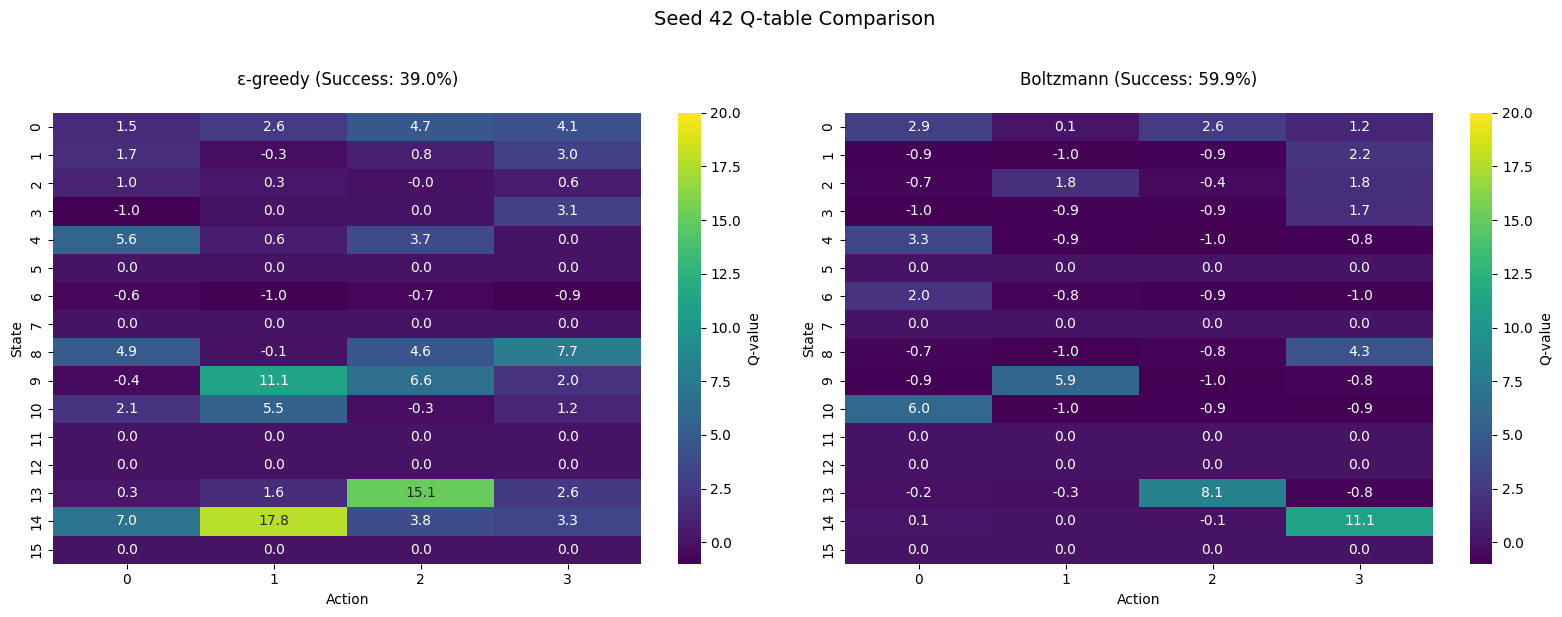

Seed 123 success rates: ε-greedy: 29.8%, Boltzmann: 71.8%


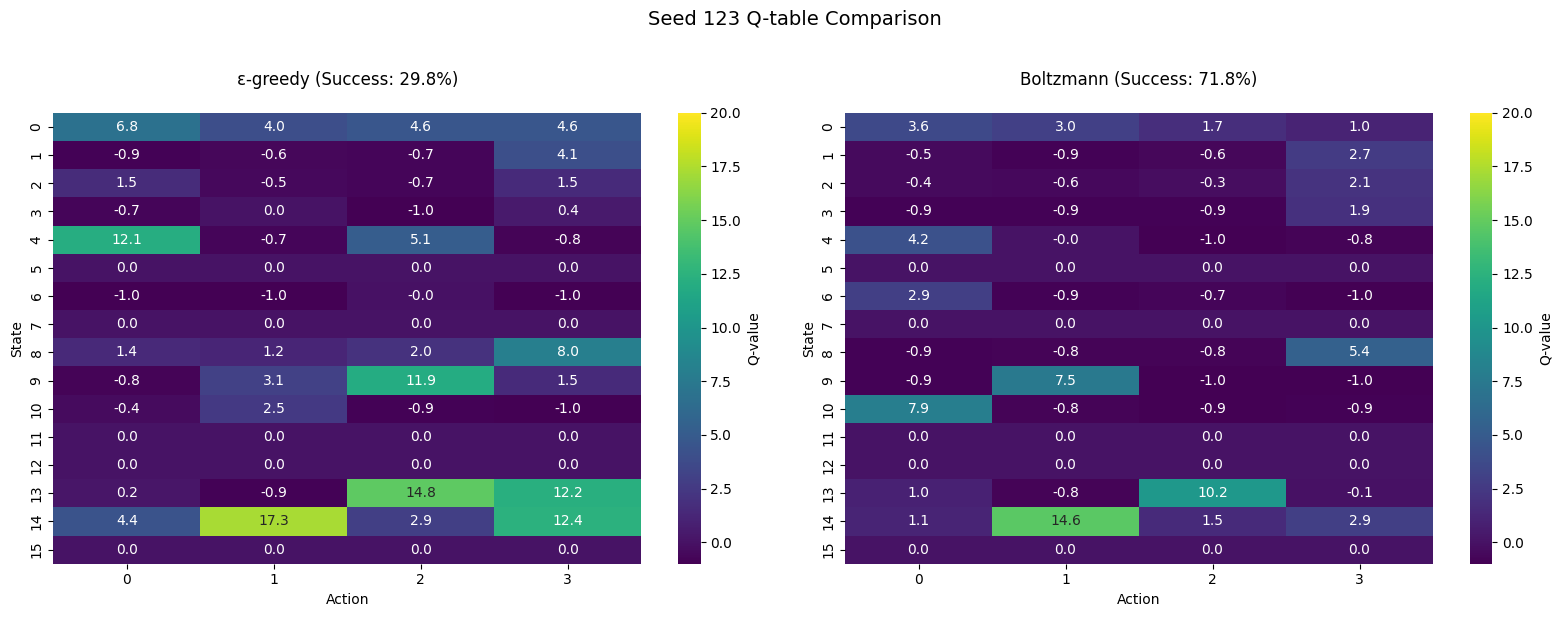

Seed 456 success rates: ε-greedy: 70.8%, Boltzmann: 58.6%


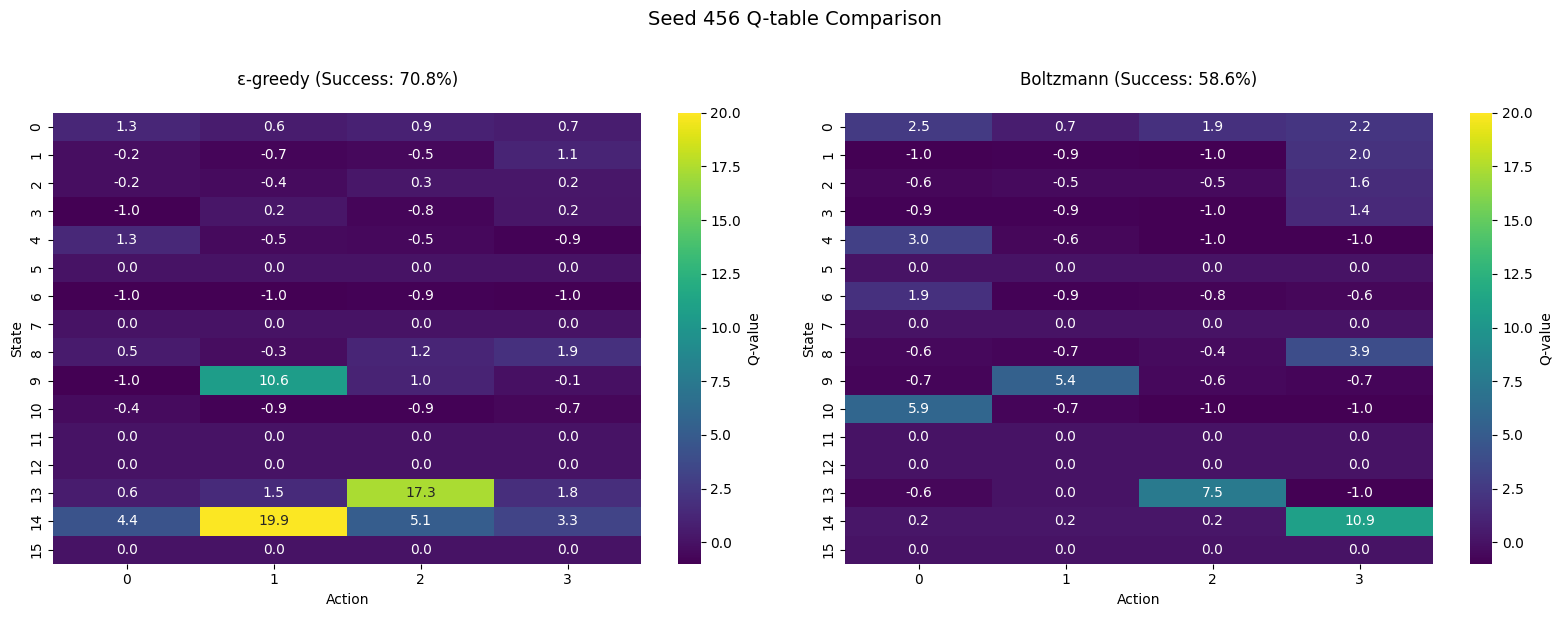


Final Statistics:
ε-Greedy - Average: 46.5%, Best: 70.8%, Worst: 29.8%
Boltzmann - Average: 63.4%, Best: 71.8%, Worst: 58.6%


In [31]:
# Initialize configuration
config = Config()

# Run comparison (this will print results and show plots automatically)
results = run_comparison(config)

# Final statistics
eps_rates = [r[1] for r in results]
boltz_rates = [r[2] for r in results]

print("\nFinal Statistics:")
print(f"ε-Greedy - Average: {np.mean(eps_rates):.1%}, " +
      f"Best: {max(eps_rates):.1%}, Worst: {min(eps_rates):.1%}")
print(f"Boltzmann - Average: {np.mean(boltz_rates):.1%}, " +
      f"Best: {max(boltz_rates):.1%}, Worst: {min(boltz_rates):.1%}")

### Performance Comparison Plot

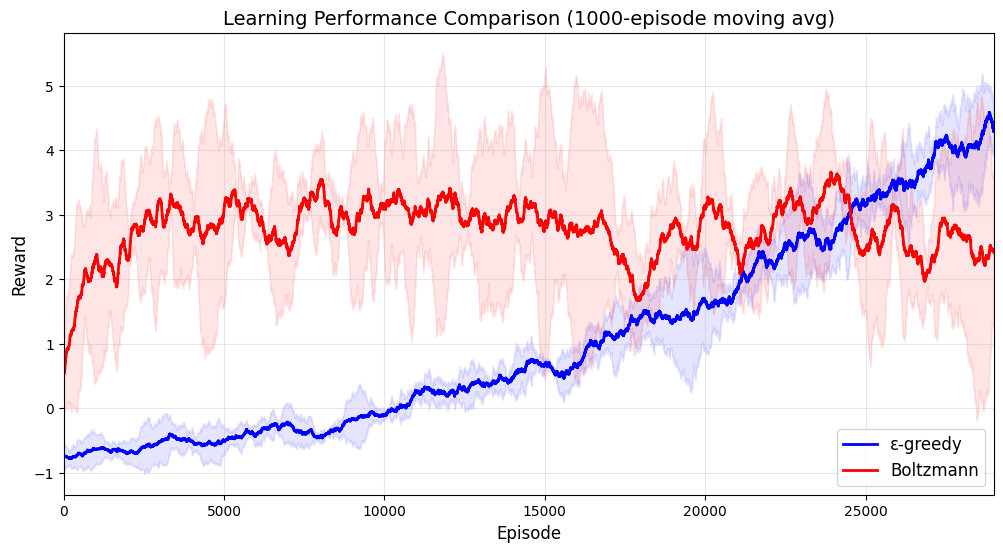

In [11]:
def plot_combined_performance(config, seeds=SEEDS):
    """Plot moving average rewards for both strategies across all seeds"""
    plt.figure(figsize=(12, 6))
    
    # Collect all rewards
    all_eps_rewards = []
    all_boltz_rewards = []
    
    for seed in seeds:
        # Train ε-greedy
        config.epsilon = 1.0
        env = create_env(config.slippery)
        _, eps_rewards = train_epsilon_greedy(config, env, seed)
        all_eps_rewards.append(eps_rewards)
        
        # Train Boltzmann
        env = create_env(config.slippery)
        _, boltz_rewards = train_boltzmann(config, env, seed)
        all_boltz_rewards.append(boltz_rewards)
    
    # Compute moving averages (window=1000 for smoother plot)
    eps_ma = np.mean([np.convolve(r, np.ones(1000)/1000, mode='valid') for r in all_eps_rewards], axis=0)
    boltz_ma = np.mean([np.convolve(r, np.ones(1000)/1000, mode='valid') for r in all_boltz_rewards], axis=0)
    
    # Plot with 95% confidence intervals
    eps_std = np.std([np.convolve(r, np.ones(1000)/1000, mode='valid') for r in all_eps_rewards], axis=0)
    boltz_std = np.std([np.convolve(r, np.ones(1000)/1000, mode='valid') for r in all_boltz_rewards], axis=0)
    
    plt.plot(eps_ma, 'b-', label='ε-greedy', linewidth=2)
    plt.fill_between(range(len(eps_ma)), 
                     eps_ma - 1.96*eps_std, 
                     eps_ma + 1.96*eps_std,
                     color='blue', alpha=0.1)
    
    plt.plot(boltz_ma, 'r-', label='Boltzmann', linewidth=2)
    plt.fill_between(range(len(boltz_ma)), 
                     boltz_ma - 1.96*boltz_std, 
                     boltz_ma + 1.96*boltz_std,
                     color='red', alpha=0.1)
    
    plt.title("Learning Performance Comparison (1000-episode moving avg)", fontsize=14)
    plt.xlabel("Episode", fontsize=12)
    plt.ylabel("Reward", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.xlim(0, config.episodes-1000)  # Adjust for moving average window
    plt.show()

# Generate the comparison plot
plot_combined_performance(config)

# Experiment 3: How Q-values propagate (craving) and show optimal policies with arrows

### Initial Setup

In [32]:
SEEDS = [42, 123, 456]
np.random.seed(42)

class Config:
    def __init__(self, slippery=True):
        self.alpha = 0.8
        self.gamma = 0.95
        self.epsilon = 1.0
        self.min_epsilon = 0.05
        self.epsilon_decay = 0.9999
        self.episodes = 50000
        self.eval_episodes = 1000
        self.slippery = slippery
        self.reward_goal = 20
        self.reward_hole = -1
        self.reward_step = -0.01

### Q-Learning Algorithm

In [33]:
def train_q_learning(config, env, seed):
    """Train Q-learning with ε-greedy exploration"""
    np.random.seed(seed)
    env.reset(seed=seed)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []
    
    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            if np.random.random() < config.epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Reward shaping
            if terminated and reward == 0:
                reward = config.reward_hole
            elif reward == 1:
                reward = config.reward_goal
            else:
                reward = config.reward_step
            
            # Q-learning update
            q_table[state, action] += config.alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )
            
            state = next_state
            total_reward += reward
        
        # Decay epsilon
        config.epsilon = max(config.min_epsilon, config.epsilon * config.epsilon_decay)
        episode_rewards.append(total_reward)
    
    return q_table, episode_rewards

### Evaluate Policy

In [34]:
def evaluate(q_table, config, seed):
    eval_env = gym.make("FrozenLake-v1",
                        desc=["SFFF",
                              "FHFH", 
                              "FFFH", 
                              "HFFG"],
                        is_slippery=config.slippery)
    eval_env.reset(seed=seed+1000)
    successes = 0
    
    for _ in range(config.eval_episodes):
        state, _ = eval_env.reset()
        done = False
        while not done:
            action = np.argmax(q_table[state])
            state, _, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            if terminated and state == 15:
                successes += 1
    
    return successes / config.eval_episodes

### Heatmap and Craving Visualization

In [35]:
def plot_q_table(q_table):
    """Plot heatmap of max Q-values and arrows for optimal policy"""
    grid_size = 4
    q_max = np.max(q_table, axis=1).reshape((grid_size, grid_size))
    q_policy = np.argmax(q_table, axis=1).reshape((grid_size, grid_size))

    plt.figure(figsize=(6, 6))
    sns.heatmap(q_max, annot=True, cmap="YlGnBu", cbar=True, square=True, 
                xticklabels=False, yticklabels=False)
    plt.title("Q-Value Heatmap (Max per State)", fontsize=14)
    
    # Define hole positions in the 4x4 map
    holes = [0, 0, 0, 0,
             0, 1, 0, 1,
             0, 0, 0, 1,
             1, 0, 0, 0]  # 1 = hole

    # Add arrows only for non-hole cells
    for y in range(grid_size):
        for x in range(grid_size):
            state = y * grid_size + x
            if holes[state]:  # Don't plot arrows on holes
                continue
            
            action = q_policy[y, x]
            dx, dy = 0, 0
            if action == 0: dy = -0.3  # Up
            elif action == 1: dx = 0.3  # Right
            elif action == 2: dy = 0.3  # Down
            elif action == 3: dx = -0.3  # Left
            plt.arrow(x + 0.5, y + 0.5, dx, dy, head_width=0.1, color='red')

    plt.gca()
    plt.show()


### Main Execution

Success rate: 16.30%


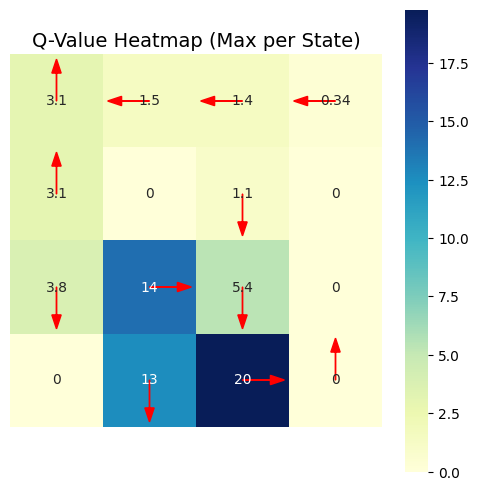

In [36]:
config = Config(slippery=True)
env = gym.make("FrozenLake-v1", 
               desc=["SFFF",
                     "FHFH", 
                     "FFFH", 
                     "HFFG"],
               is_slippery=config.slippery)

q_table, rewards = train_q_learning(config, env, seed=42)
success_rate = evaluate(q_table, config, seed=42)
print(f"Success rate: {success_rate:.2%}")
plot_q_table(q_table)


# Experiment 4: Comparison of different reward_hole values

### Config

In [43]:
class Config:
    def __init__(self, alpha=0.8, gamma=0.95, epsilon=1.0, min_epsilon=0.05, epsilon_decay=0.9999,
                 episodes=30000, eval_episodes=1000, slippery=True, reward_hole=-5):  
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.episodes = episodes
        self.eval_episodes = eval_episodes
        self.slippery = slippery
        self.reward_goal = 20
        self.reward_hole = reward_hole 
        self.reward_step = -0.01


### Q-Learning Algorithm

In [44]:
def train_q_learning_with_custom_hole_penalty(config, env, seed):
    """Train Q-learning with a custom hole penalty"""
    np.random.seed(seed)
    env.reset(seed=seed)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []
    
    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            if np.random.random() < config.epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Reward shaping
            if terminated and reward == 0:
                reward = config.reward_hole  # Custom hole penalty
            elif reward == 1:
                reward = config.reward_goal
            else:
                reward = config.reward_step
            
            # Q-learning update
            q_table[state, action] += config.alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )
            
            state = next_state
            total_reward += reward
        
        # Decay epsilon
        config.epsilon = max(config.min_epsilon, config.epsilon * config.epsilon_decay)
        episode_rewards.append(total_reward)
    
    return q_table, episode_rewards

### Evaluation function

In [45]:
def evaluate_policy(q_table, env, eval_episodes=1000):
    """Evaluate the learned policy and return success rate"""
    successes = 0
    for _ in range(eval_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = np.argmax(q_table[state])
            state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if terminated and state == 15:  # Goal state
                successes += 1
    success_rate = successes / eval_episodes
    return success_rate

### Plot Heatmaps

In [46]:
def plot_hole_penalty_comparison(results, hole_rewards):
    """Plot comparison of performance with different hole penalties"""
    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting
    for reward in hole_rewards:
        # Find the corresponding result for this hole penalty
        result = next(item for item in results if item['reward'] == reward)
        
        # Get all rewards for this hole penalty
        all_rewards = [result['rewards']]
        
        # Compute moving average (window=1000)
        ma_rewards = np.mean([np.convolve(r, np.ones(1000)/1000, mode='valid') for r in all_rewards], axis=0)
        
        # Compute average success rate
        avg_success = result['success_rate']
        
        # Plot the moving average of rewards
        plt.plot(ma_rewards, label=f"Hole Penalty: {reward} (Avg SR: {avg_success:.1%})", linewidth=2)
    
    plt.title("Hole Penalty Comparison (1000-episode MA)", fontsize=14)
    plt.xlabel("Episode", fontsize=12)
    plt.ylabel("Reward", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.xlim(0, 29000)  # Adjust for moving average window
    plt.show()


In [47]:
def plot_q_tables(q_tables, hole_rewards, success_rates):
    """Plot Q-tables for different hole penalties"""
    plt.figure(figsize=(15, 5 * len(hole_rewards)))
    
    for i, (q_table, reward, sr) in enumerate(zip(q_tables, hole_rewards, success_rates)):
        plt.subplot(len(hole_rewards), 1, i+1)
        sns.heatmap(q_table, annot=True, fmt=".1f", cmap="viridis", 
                   cbar_kws={'label': 'Q-value'}, vmin=-5, vmax=20)
        plt.title(f"Q-table with Hole Penalty = {reward} (Success Rate: {sr:.1%})", pad=20)
        plt.xlabel("Action")
        plt.ylabel("State")
    
    plt.tight_layout()
    plt.show()


### Main execution


=== Success Rate Comparison ===
Hole Penalty: -5 	 Success Rate: 27.4%
Hole Penalty: -1 	 Success Rate: 73.9%
Hole Penalty: -0.5 	 Success Rate: 72.4%


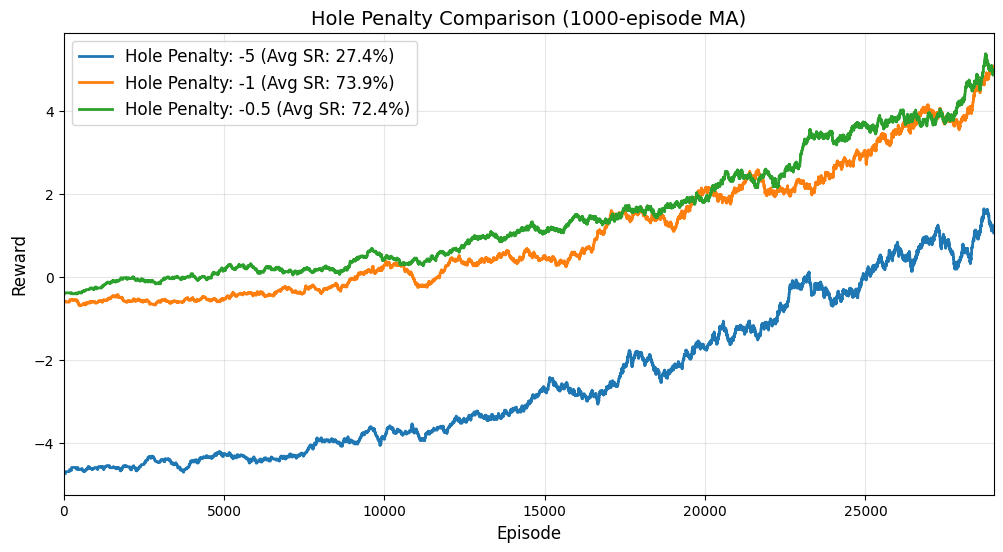

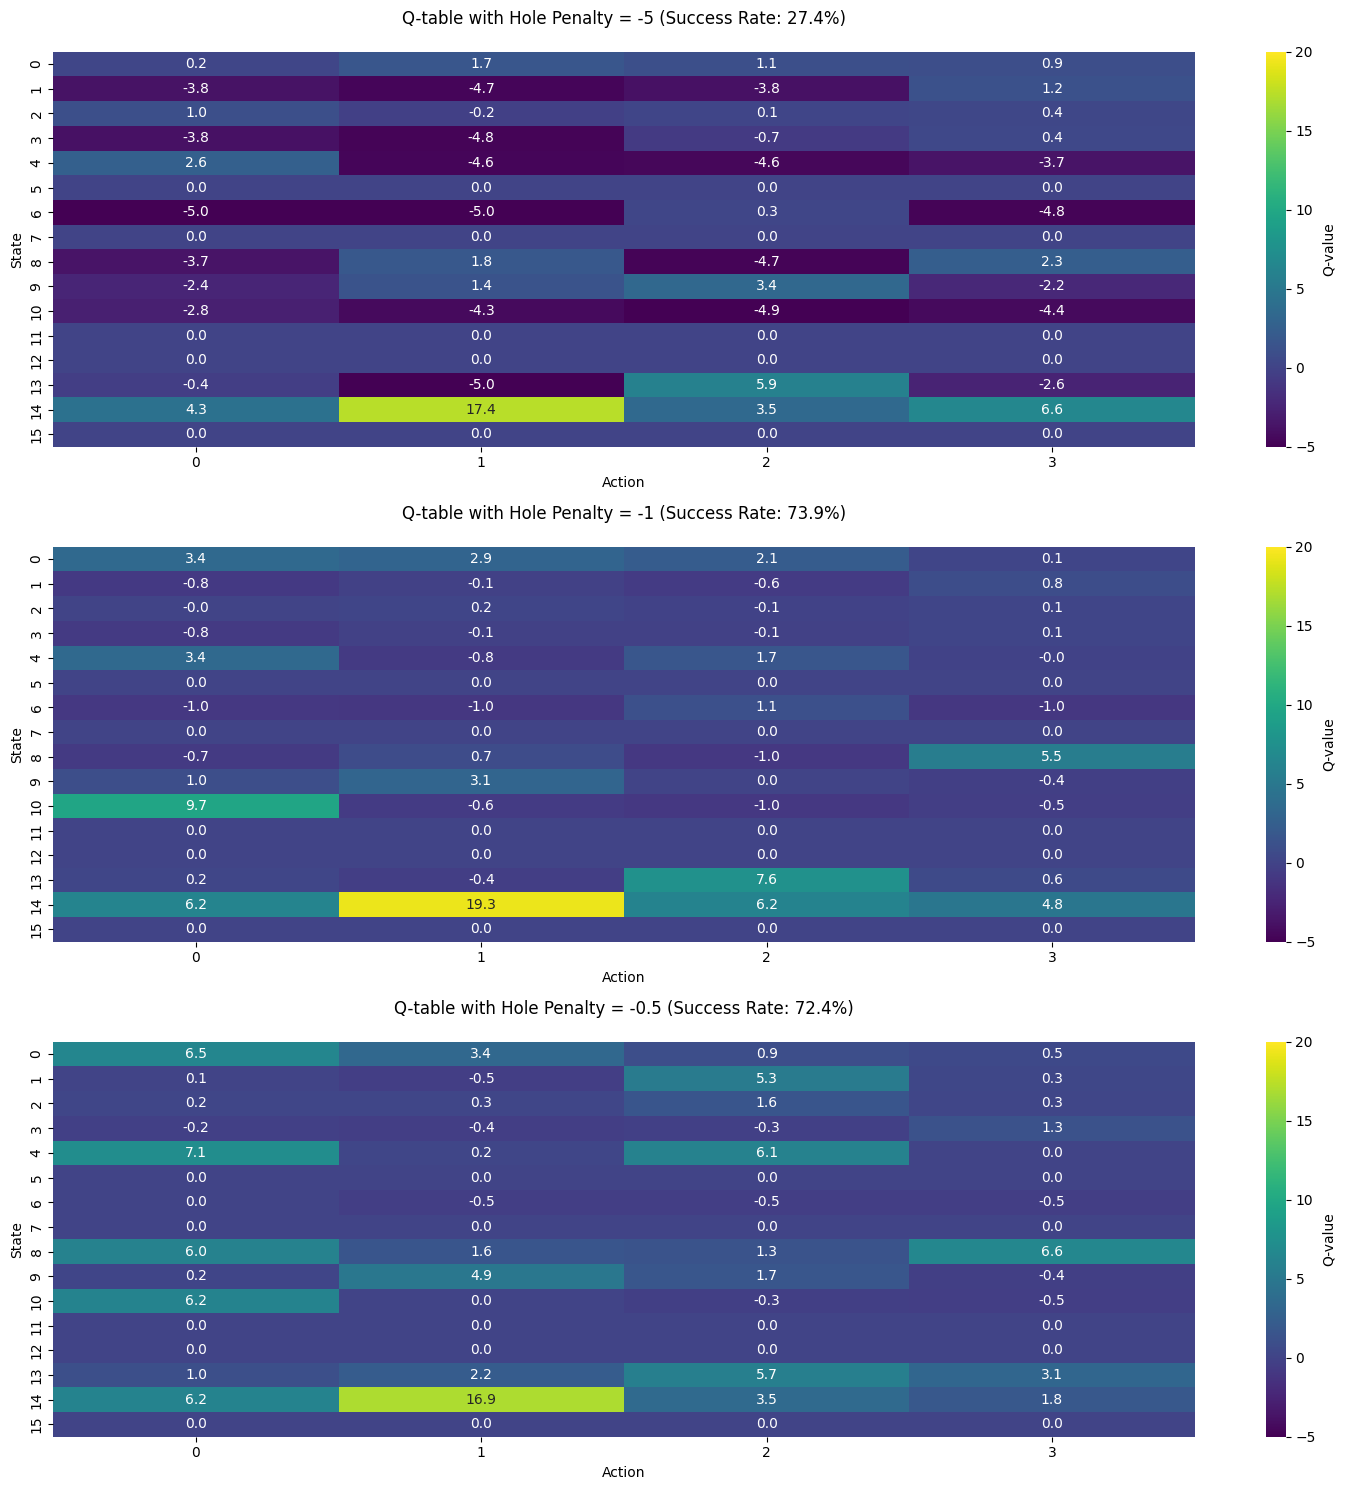

In [49]:
if __name__ == "__main__":
    env = gym.make("FrozenLake-v1", desc=["SFFF", "FHFH", "FFFH", "HFFG"], is_slippery=True)
    seed = 42

    # Define different hole penalties to test
    hole_rewards = [-5, -1, -0.5]

    # Initialize storage
    results = []
    q_tables = []
    success_rates = []

    # Train and evaluate with different hole penalties
    for reward in hole_rewards:
        config = Config(reward_hole=reward)
        q_table, rewards = train_q_learning_with_custom_hole_penalty(config, env, seed)
        success_rate = evaluate_policy(q_table, env)
        
        results.append({
            'reward': reward,
            'rewards': rewards,
            'success_rate': success_rate
        })
        q_tables.append(q_table)
        success_rates.append(success_rate)

    # Display success rates
    print("\n=== Success Rate Comparison ===")
    for result in results:
        print(f"Hole Penalty: {result['reward']} \t Success Rate: {result['success_rate']:.1%}")

    # Plot the reward progression
    plot_hole_penalty_comparison(results, hole_rewards)
    
    # ADD THIS LINE TO PLOT Q-TABLES
    plot_q_tables(q_tables, hole_rewards, success_rates)

# Experiment 5: Experience Replay

### Experience Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, min(len(self.buffer), batch_size))

    def __len__(self):
        return len(self.buffer)

### Config

In [57]:
class Config:
    def __init__(self, alpha=0.8, gamma=0.95, epsilon=1.0, min_epsilon=0.05, epsilon_decay=0.9999,
                 episodes=30000, eval_episodes=1000, replay=False, slippery=True):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.episodes = episodes
        self.eval_episodes = eval_episodes
        self.replay = replay  
        self.reward_goal = 20
        self.reward_hole = -1
        self.reward_step = -0.01
        self.slippery = slippery

### Q-learning Algorithm

In [63]:
def train_q_learning_with_replay(config, env, seed):
    np.random.seed(seed)
    env.reset(seed=seed)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []
    replay_buffer = deque(maxlen=1000)

    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            if np.random.random() < config.epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Reward shaping
            if terminated and reward == 0:
                reward = config.reward_hole
            elif reward == 1:
                reward = config.reward_goal
            else:
                reward = config.reward_step


            # Store experience
            replay_buffer.append((state, action, reward, next_state))

            # Sample from buffer and update Q-table
            if len(replay_buffer) >= 32:
                batch = random.sample(replay_buffer, 32)
                for s, a, r, ns in batch:
                    q_table[s, a] += config.alpha * (
                        r + config.gamma * np.max(q_table[ns]) - q_table[s, a]
                    )

            state = next_state
            total_reward += reward

        config.epsilon = max(config.min_epsilon, config.epsilon * config.epsilon_decay)
        episode_rewards.append(total_reward)

    return q_table, episode_rewards

# Q-learning without replay
def train_q_learning_without_replay(config, env, seed):
    np.random.seed(seed)
    env.reset(seed=seed)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []

    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            if np.random.random() < config.epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Reward shaping
            if terminated and reward == 0:
                reward = config.reward_hole
            elif reward == 1:
                reward = config.reward_goal
            else:
                reward = config.reward_step

            # Q-update
            q_table[state, action] += config.alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )

            state = next_state
            total_reward += reward

        config.epsilon = max(config.min_epsilon, config.epsilon * config.epsilon_decay)
        episode_rewards.append(total_reward)

    return q_table, episode_rewards

In [64]:
def evaluate_policy(q_table, env, config):
    successes = 0
    for _ in range(config.eval_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = np.argmax(q_table[state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
        if reward > 0:
            successes += 1
    return successes / config.eval_episodes

### Visualizing Heatmap

In [65]:
def plot_comparison_q_table(q_table_no_replay, q_table_replay, seed, eps_success_no_replay, eps_success_replay):
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(q_table_no_replay.reshape((4, 4, 4)).max(axis=-1), annot=True, fmt=".1f", cmap="viridis", 
                cbar_kws={'label': 'Q-value'}, vmin=-1, vmax=20)
    plt.title(f"Without Replay (Success: {eps_success_no_replay:.1%})", pad=20)
    plt.xlabel("Column")
    plt.ylabel("Row")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(q_table_replay.reshape((4, 4, 4)).max(axis=-1), annot=True, fmt=".1f", cmap="viridis", 
                cbar_kws={'label': 'Q-value'}, vmin=-1, vmax=20)
    plt.title(f"With Replay (Success: {eps_success_replay:.1%})", pad=20)
    plt.xlabel("Column")
    plt.ylabel("Row")
    
    plt.suptitle(f"Q-table Comparison (Seed {seed})", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

### Training and Evaluation

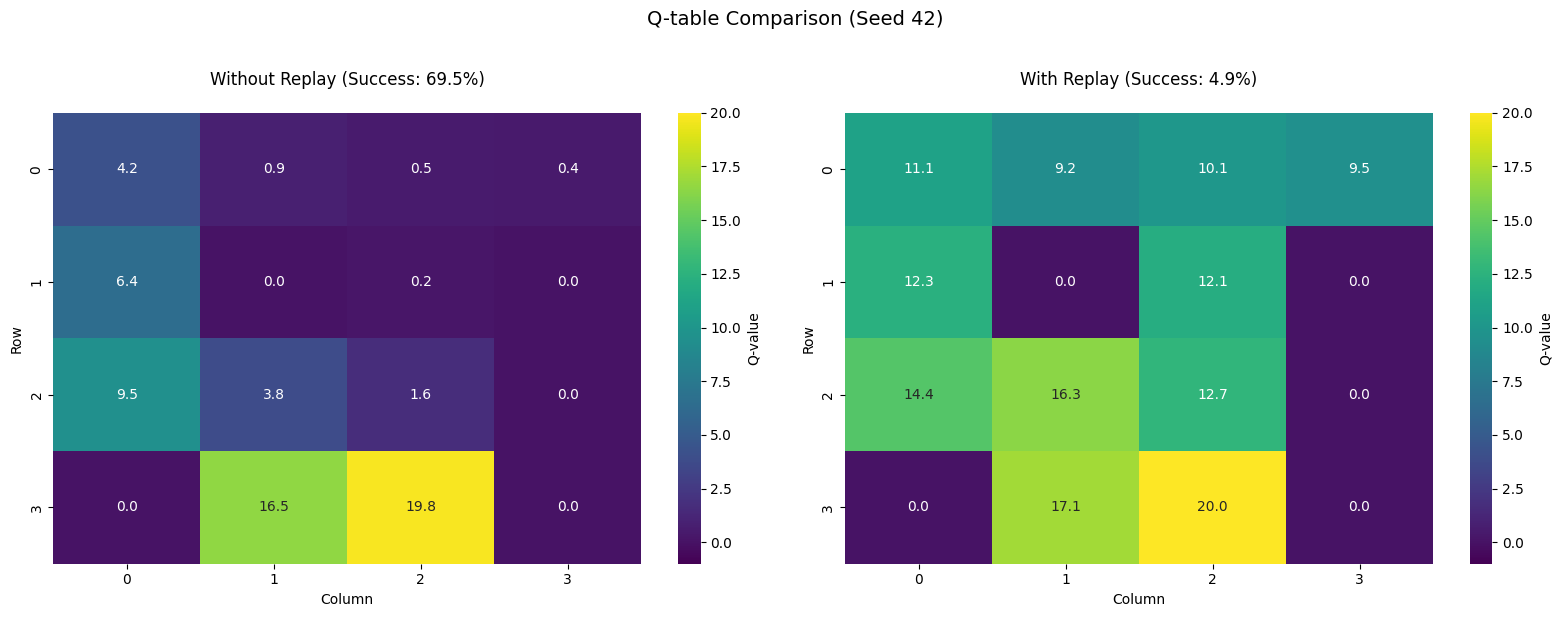

In [66]:
# Environment
env = gym.make("FrozenLake-v1", desc=["SFFF", "FHFH", "FFFH", "HFFG"], is_slippery=True)
seed = 42

# Configurations
config_no_replay = Config(replay=False)
config_replay = Config(replay=True)

# Train
q_table_no_replay, _ = train_q_learning_without_replay(config_no_replay, env, seed)
q_table_replay, _ = train_q_learning_with_replay(config_replay, env, seed)

# Evaluate
eps_success_no_replay = evaluate_policy(q_table_no_replay, env, config_no_replay)
eps_success_replay = evaluate_policy(q_table_replay, env, config_replay)

# Visualize
plot_comparison_q_table(q_table_no_replay, q_table_replay, seed, 
                        eps_success_no_replay, eps_success_replay)

# Experiment 6:  Providing Frozen Lake Layout

### Config

In [77]:
class Config:
    def __init__(self, alpha=0.8, gamma=0.95, epsilon=1.0, min_epsilon=0.05, epsilon_decay=0.9999,
                 episodes=30000, eval_episodes=1000, slippery=True):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.episodes = episodes
        self.eval_episodes = eval_episodes
        self.slippery = slippery

lake_map = [
    [0, 0, 0, 0],  # SFFF
    [0, 1, 0, 1],  # FHFH
    [0, 0, 0, 1],  # FFFH
    [1, 0, 0, 2]   # HFFG
]

def map_state_to_position(state):
    row = state // 4
    col = state % 4
    return row, col

### Q-learning Algorithm

In [78]:
def train_q_learning_with_map_knowledge(config, env, seed, map_data):
    np.random.seed(seed)
    env.reset(seed=seed)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []

    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            if np.random.random() < config.epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            row, col = map_state_to_position(state)
            cell_type = map_data[row][col]

            if terminated:
                reward = 20 if cell_type == 2 else -10
            else:
                reward = -0.01
                goal_dist = (3 - row) + (3 - col)
                reward += 0.1 * (8 - goal_dist)

            q_table[state, action] += config.alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )

            if cell_type == 0:
                q_table[state, action] += config.alpha * 0.5 * (
                    reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
                )

            state = next_state
            total_reward += reward

        config.epsilon = max(config.min_epsilon, config.epsilon * config.epsilon_decay)
        episode_rewards.append(total_reward)

    return q_table, episode_rewards

def train_q_learning_without_map_knowledge(config, env, seed):
    np.random.seed(seed)
    env.reset(seed=seed)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []

    for episode in range(config.episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            if np.random.random() < config.epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                reward = 20 if state == 15 else -10
            else:
                reward = -0.01

            q_table[state, action] += config.alpha * (
                reward + config.gamma * np.max(q_table[next_state]) - q_table[state, action]
            )

            state = next_state
            total_reward += reward

        config.epsilon = max(config.min_epsilon, config.epsilon * config.epsilon_decay)
        episode_rewards.append(total_reward)

    return q_table, episode_rewards

### Evaluation

In [79]:
def evaluate_policy(q_table, env, eval_episodes=1000):
    successes = 0
    for _ in range(eval_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = np.argmax(q_table[state])
            state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if terminated and state == 15:
                successes += 1
    return successes / eval_episodes

### Plotting Heatmap

In [80]:
def plot_q_table(q_table, title="Q-table", vmin=-1, vmax=20):
    plt.figure(figsize=(10, 6))
    sns.heatmap(q_table, annot=True, fmt=".1f", cmap="viridis", cbar_kws={'label': 'Q-value'}, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlabel("Action")
    plt.ylabel("State")
    plt.show()

### Main Execution

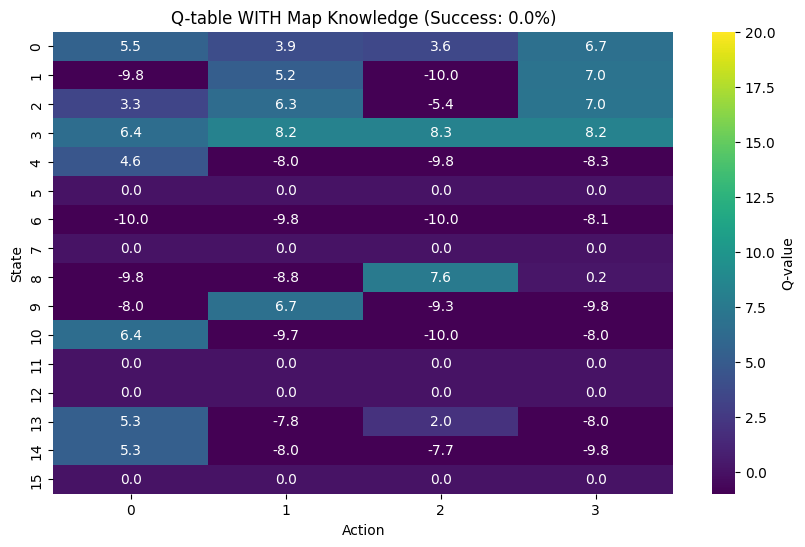

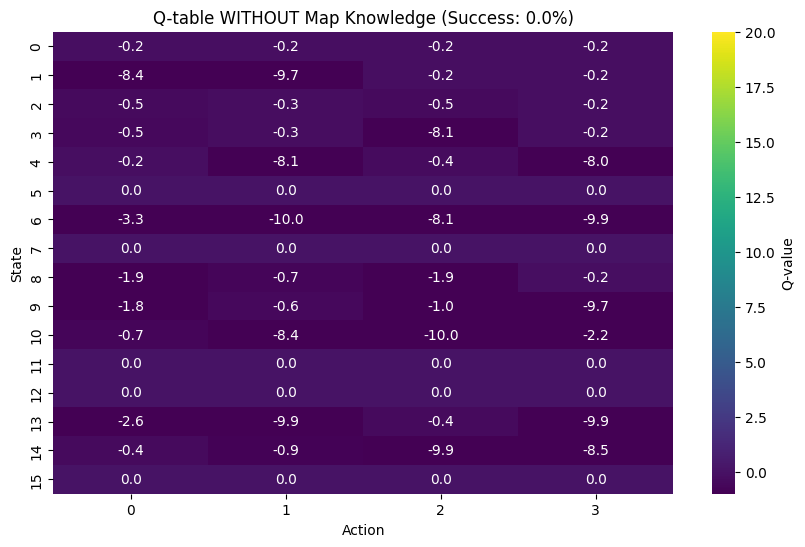

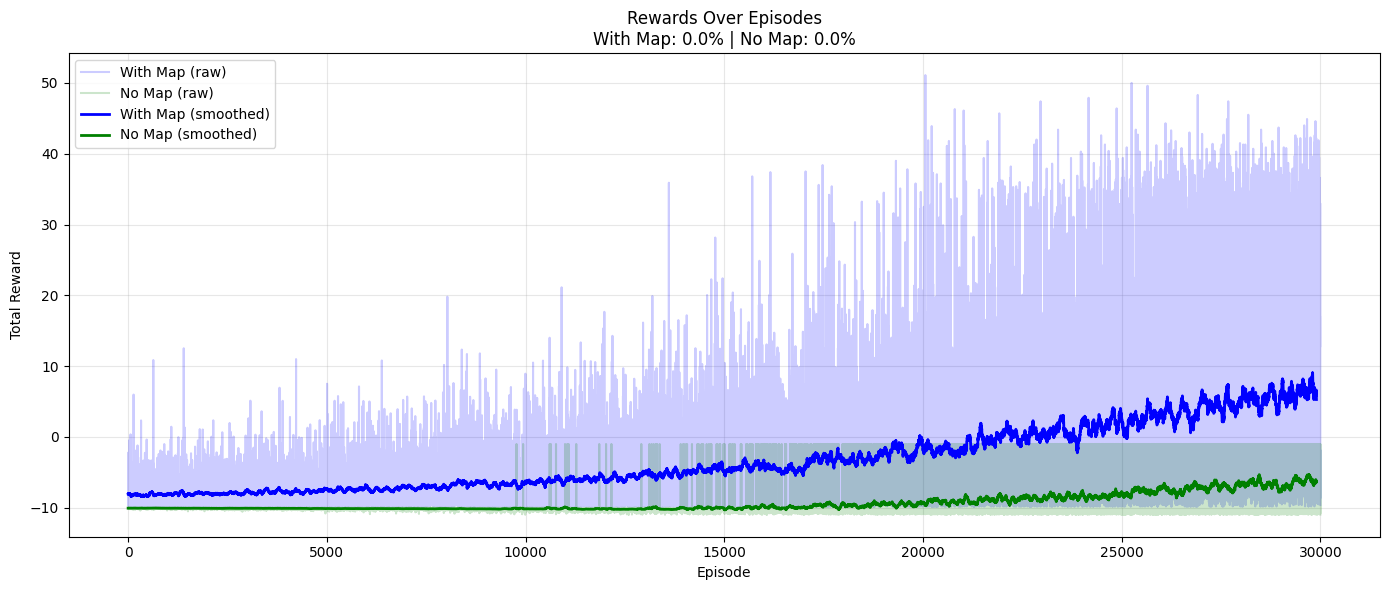

In [82]:
env = gym.make("FrozenLake-v1", desc=["SFFF", "FHFH", "FFFH", "HFFG"], is_slippery=True)
seed = 42

# With map knowledge
config_map = Config()
q_map, rewards_map = train_q_learning_with_map_knowledge(config_map, env, seed, lake_map)
success_map = evaluate_policy(q_map, env)
plot_q_table(q_map, title=f"Q-table WITH Map Knowledge (Success: {success_map:.1%})")

# Without map knowledge
config_nomap = Config()
q_nomap, rewards_nomap = train_q_learning_without_map_knowledge(config_nomap, env, seed)
success_nomap = evaluate_policy(q_nomap, env)
plot_q_table(q_nomap, title=f"Q-table WITHOUT Map Knowledge (Success: {success_nomap:.1%})")

# --------- Compare reward curves ---------
plt.figure(figsize=(14, 6))
window = 100
smoothed_map = np.convolve(rewards_map, np.ones(window)/window, mode='valid')
smoothed_nomap = np.convolve(rewards_nomap, np.ones(window)/window, mode='valid')

plt.plot(rewards_map, alpha=0.2, label="With Map (raw)", color="blue")
plt.plot(rewards_nomap, alpha=0.2, label="No Map (raw)", color="green")
plt.plot(smoothed_map, label="With Map (smoothed)", color="blue", linewidth=2)
plt.plot(smoothed_nomap, label="No Map (smoothed)", color="green", linewidth=2)

plt.title(f"Rewards Over Episodes\nWith Map: {success_map:.1%} | No Map: {success_nomap:.1%}")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()